**Chargement du dataset**

In [1]:
import pandas as pd
import traceback
import matplotlib.pyplot as plt
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

try:
    data = pd.read_csv('train.csv')
    df = data.copy()

except Exception as e:
    traceback.print_exc()

**Visualisation des données**

In [3]:
data.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [4]:
data.tail(10)

,essay_id,full_text,score
17297,ffbd0b4,Do you think you could suvive in another plane...,2
17298,ffc11a8,You should join the Seagoing Cowboys because y...,3
17299,ffc9095,"Venus, an extraordinary planet because of many...",3
17300,ffcb061,Becoming a Seagoing Cowboy is a once in a life...,3
17301,ffcb264,Using technology is a good way to help other i...,2
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1
17306,fffed3e,Venus is worthy place to study but dangerous. ...,2


**Analyse des données**

In [5]:
data.describe()

,score
count,17307.000000
mean,2.948402
std,1.044899
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [7]:

data['score'].describe()

count    17307.000000
mean         2.948402
std          1.044899
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: score, dtype: float64

In [8]:
mean_score = data['score'].mean()
# Nombre de scores au-dessus de la moyenne
above_mean = (data['score'] > mean_score).sum()
print(above_mean)
# Nombre de scores en dessous de la moyenne
below_mean = (data['score'] < mean_score).sum()
print(below_mean)

#Nombre de scores qui sont à la moyenne
on_mean = (data['score'] == mean_score).sum()
print(on_mean)

11332
5975
0


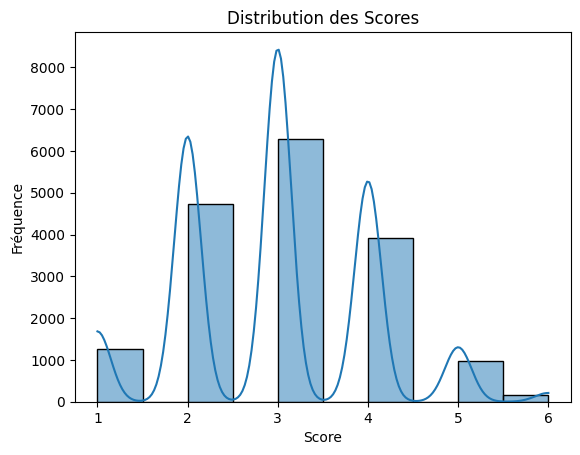

In [9]:
sns.histplot(data['score'], bins=10, kde=True)
plt.title('Distribution des Scores')
plt.xlabel('Score')
plt.ylabel('Fréquence')
plt.show()

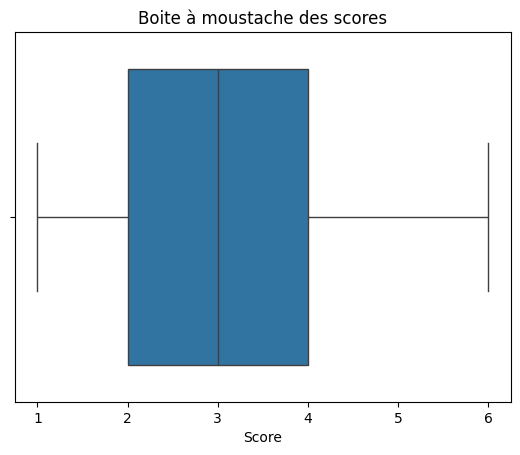

In [10]:
sns.boxplot(x=data['score'])
plt.title('Boite à moustache des scores')
plt.xlabel('Score')
plt.show()

**Remarques tirées de l'analyse sur la distribution des scores:**



1.   Il y a plus de scores au dessus de la moyenne que de scores au dessous( le double)
2.   Peut-ềtre que cela nous causera un problème lors de l'entraînement du model, il va apprendre plus sur les bons essais que les mauvais ( On verra comment traiter ça)



Une autre analyse que nous souhaitons réaliser est:
Comme nous ne connaissons pas le thème de ces rédactions( on ne sait pas s'il y a un seul thème ou plusieurs), nous allons essayer de faire un clustering d'abord pour voir ça

Pour faire cela, nous allons taiter d'abord nos données


**Pre Processing**

La fonction preprocess_text nettoie le texte en le convertissant en minuscules, en supprimant les chiffres et en remplaçant les caractères non alphabétiques par des espaces, puis est appliquée à chaque entrée de la colonne 'full_text' du DataFrame data

In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove non-word characters
    return text

data['full_text'] = data['full_text'].apply(preprocess_text)


In [13]:
data['full_text']

0        many people have car where they live the thing...
1        i am a scientist at nasa that is discussing th...
2        people always wish they had the same technolog...
3        we all heard about venus the planet without al...
4        dear state senator this is a letter to argue i...
                               ...                        
17302    the story the challenge of exploing venus is a...
17303    technology has changed a lot of ways that we l...
17304    if you don t like sitting around all day than ...
17305    in the challenge of exporing venus the author ...
17306    venus is worthy place to study but dangerous t...
Name: full_text, Length: 17307, dtype: object

La fonction remove_puncs nettoie le texte en supprimant tous les caractères qui ne sont pas des lettres ou des espaces

In [14]:
def remove_puncs(text):
    essay = re.sub("[^A-Za-z ]","",text)
    return essay

data['full_text'] = data['full_text'].apply(remove_puncs)

In [15]:
data['full_text']

0        many people have car where they live the thing...
1        i am a scientist at nasa that is discussing th...
2        people always wish they had the same technolog...
3        we all heard about venus the planet without al...
4        dear state senator this is a letter to argue i...
                               ...                        
17302    the story the challenge of exploing venus is a...
17303    technology has changed a lot of ways that we l...
17304    if you don t like sitting around all day than ...
17305    in the challenge of exporing venus the author ...
17306    venus is worthy place to study but dangerous t...
Name: full_text, Length: 17307, dtype: object

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
from nltk.corpus import stopwords

La fonction remove_stop_words retire les mots vides (stop words) du texte en anglais, utilisant une liste préétablie

In [18]:
stop_words = set(stopwords.words('english'))

def remove_stop_words(essay):
    word_tokens = word_tokenize(essay)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

data['full_text'] = data['full_text'].apply(lambda x:remove_stop_words(x))

In [40]:
data['full_text']
df1 = data.copy()

 TfidfVectorizer de scikit-learn pour convertir le texte de la colonne 'full_text' du DataFrame data en une matrice de caractéristiques TF-IDF, qui quantifie l'importance des mots dans les documents tout en tenant compte de leur fréquence dans l'ensemble du corpus.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(data['full_text'])


In [42]:
X

<17307x63732 sparse matrix of type '<class 'numpy.float64'>'
	with 2025359 stored elements in Compressed Sparse Row format>

Ce que nous proposons est de faire un clustring sur les rédactions avec k means pour voir s'il y  a des thèmes différents de textes et si cela peut être utile dans notre cas d'usage

**K-means**

In [43]:
from sklearn.cluster import KMeans

k = 5
model = KMeans(n_clusters=k, random_state=42)
model.fit(X)
labels = model.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
import numpy as np
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(labels).mean()

    terms = tfidf_vectorizer.get_feature_names_out()
    for i, r in df.iterrows():
        print('\nCluster {}:'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords(X, model, labels, 10)



Cluster 0:
luke,could,computer,student,technology,facial,seagoing,help,emotions,students

Cluster 1:
usage,could,drive,people,would,driver,driving,driverless,car,cars

Cluster 2:
created,mesa,picture,nasa,alien,natural,aliens,landform,mars,face

Cluster 3:
voting,state,election,popular,votes,electors,president,college,vote,electoral

Cluster 4:
conditions,nasa,studying,study,dangers,surface,author,earth,planet,venus


Avec 5 clusters, on voit déja qu'il y un cluser particulier(3) parlant d'éléctions, le(1) parlant de conduite/voitures, le (0) de téchnologie et ordinateur et les 2 autres se rapprochent un peu ( nana, planet, mars, venus)

On va diminuer le nombre de clusters à 4

In [45]:
k = 4
model = KMeans(n_clusters=k, random_state=42)
model.fit(X)
labels = model.labels_
print(labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 2 1 ... 2 0 2]


In [25]:
len(labels)

17307

In [26]:
import numpy as np
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(labels).mean()
    # Use get_feature_names_out() instead of get_feature_names()
    terms = tfidf_vectorizer.get_feature_names_out()
    for i, r in df.iterrows():
        print('\nCluster {}:'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords(X, model, labels, 10)


Cluster 0:
conditions,nasa,studying,study,dangers,surface,author,earth,planet,venus

Cluster 1:
usage,could,drive,people,would,driver,driving,driverless,car,cars

Cluster 2:
would,technology,facial,could,seagoing,help,emotions,students,mars,face

Cluster 3:
voting,state,election,popular,votes,electors,president,college,vote,electoral


ici , nous construisons un autre dataframe, qui va avoir une nouvele colonne (theme) où assigne à chaque texte une classe par theme

In [46]:
df1
df1['theme'] = labels + 1
df1

,essay_id,full_text,score,theme
0,000d118,many people car live thing know use car alot t...,3,2
1,000fe60,scientist nasa discussing face mars explaining...,3,3
2,001ab80,people always wish technology seen movies best...,4,2
3,001bdc0,heard venus planet without almost oxygen earth...,4,1
4,002ba53,dear state senator letter argue favor keeping ...,3,4
...,...,...,...,...
17302,ffd378d,story challenge exploing venus informative pie...,2,1
17303,ffddf1f,technology changed lot ways live today nowaday...,4,3
17304,fff016d,like sitting around day great opportunity part...,2,3
17305,fffb49b,challenge exporing venus author suggests study...,1,1


In [28]:
theme_1 = df1.loc[df1['theme'] == 1]

print(theme_1)

      essay_id                                          full_text  score  \
3      001bdc0  heard venus planet without almost oxygen earth...      4   
8      0036253  challenge exploring venus storie challeng expl...      2   
20     0079f2a  text author uses facts people know like close ...      2   
25     0087059  challenge exploring venus informative text ven...      1   
27     00a3575  challege exploring venus great idea studying v...      2   
...        ...                                                ...    ...   
17296  ffb732c  story challenge exploring venus author talks p...      3   
17297  ffbd0b4  think could suvive another planet like venus w...      2   
17299  ffc9095  venus extraordinary planet many reasons fascin...      3   
17302  ffd378d  story challenge exploing venus informative pie...      2   
17305  fffb49b  challenge exporing venus author suggests study...      1   

       theme  
3          1  
8          1  
20         1  
25         1  
27         1

In [29]:
theme_2 = df1.loc[df1['theme'] == 2]

print(theme_2)

      essay_id                                          full_text  score  \
0      000d118  many people car live thing know use car alot t...      3   
2      001ab80  people always wish technology seen movies best...      4   
10     004229b  think driverless cars good idea believe could ...      2   
11     0047cb3  good oppurtunity take away stress lower air po...      2   
12     005a72e  agree driverless cars developing idea like fac...      4   
...        ...                                                ...    ...   
17285  ff988c9  countries started limit usage cars limitation ...      3   
17286  ff98dbe  google field tested driverless car drove five ...      4   
17288  ff9bb09  automobiles people relay without cars alot peo...      3   
17291  ffab5f8  driverless cars coming thats good since google...      3   
17295  ffb595e  walking jogging even riding bike ways transpor...      3   

       theme  
0          2  
2          2  
10         2  
11         2  
12         2

In [30]:
theme_3 = df1.loc[df1['theme'] == 3]

print(theme_3)

      essay_id                                          full_text  score  \
1      000fe60  scientist nasa discussing face mars explaining...      3   
6      0033037  posibilty face reconizing computer would helpf...      2   
7      0033bf4  seagoing cowboys progam help many countries sc...      3   
9      0040e27  many reasons join seagoing cowboys program wou...      3   
16     006c931  could tell people us without even asking peopl...      3   
...        ...                                                ...    ...   
17300  ffcb061  becoming seagoing cowboy lifetime chance take ...      3   
17301  ffcb264  using technology good way help classroom suffe...      2   
17303  ffddf1f  technology changed lot ways live today nowaday...      4   
17304  fff016d  like sitting around day great opportunity part...      2   
17306  fffed3e  venus worthy place study dangerous reaosn thei...      2   

       theme  
1          3  
6          3  
7          3  
9          3  
16         3

In [31]:
theme_4 = df1.loc[df1['theme'] == 4]

print(theme_4)

      essay_id                                          full_text  score  \
4      002ba53  dear state senator letter argue favor keeping ...      3   
5      0030e86  choose keeping electoral college abolishing wo...      4   
13     00613e3  election popular vote citizens government hire...      3   
40     00d4911  senator florida believe electoral college abol...      4   
41     00d576b  well favor would electoral college reason keep...      1   
...        ...                                                ...    ...   
17230  feba238  people want people want idea supported towards...      3   
17253  fef8172  many people across country would believe elect...      4   
17260  ff0aba9  electoral college good thing majority would sa...      4   
17278  ff74f94  votes president united states counted election...      5   
17289  ffa6b95  believe people able vote want president always...      4   

       theme  
4          4  
5          4  
13         4  
40         4  
41         4

Voilà, il semble que 4 clusters et le bon nombre de clusters pour nos données

Mainteanant, nous allons procéder comme suit:

1.   Appliquer des models de maching learning simples( regression linéaire, svm ou autre), évaluer le model sans prendre en considération le clustering
2.   Faire la même chose mais cette fois en prenant en considération les 4 clusters trouvés

Puis, nous allons chercher des models NLP, et les appliquer à nos données

Afin de pouvoir les comparer à la fin





Séparation en x train, x test , y train, et y test:

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import pickle

In [33]:
y = data['score']


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



**Modèles ML simples**

**Linear Regression**

In [35]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)

In [53]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 0.9610250912290094
R² Score: 0.12896131768136498


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Converting continuous predictions to categorical
y_pred_rounded = np.round(y_pred)
y_test_rounded = np.round(y_test)

accuracy = accuracy_score(y_test_rounded, y_pred_rounded)
precision = precision_score(y_test_rounded, y_pred_rounded, average='macro')
recall = recall_score(y_test_rounded, y_pred_rounded, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.3934142114384749
Precision: 0.22400730778004874
Recall: 0.22585321479051046


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test_rounded, y_pred_rounded, weights='quadratic')
print('Quadratic Weighted Kappa:', kappa)


Quadratic Weighted Kappa: 0.567275506599652


La valeur de l'erreur moyenne quadratique est très élevée, ce model n'est pas efficace pour notre cas,on va essayer un autre model

Ici, on pense que l'accuracy ne reflète pas vraiment la performance du model, du coup on utilise le kappa score qui prend en considération le rapprochement entre les données de test et ce qui est prédit, par exemple, si le score est 4 et qu'on prédit 5 ou 3, on le prend en considération car c'est proche, c'est pas comme si le score est 1 et on a prédit 5

**SVR**

In [ ]:
from sklearn.svm import SVR

# Create the SVR model with a specific kernel
svr_model = SVR(kernel='linear')


svr_model.fit(X_train, y_train)


y_pred_svr = svr_model.predict(X_test)


mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print("Mean Squared Error for SVR:", mse_svr)
print("R² Score for SVR:", r2_svr)


In [ ]:
y_pred_rounded = np.round(y_pred_svr)
y_test_rounded = np.round(y_test)

accuracy = accuracy_score(y_test_rounded, y_pred_rounded)
precision = precision_score(y_test_rounded, y_pred_rounded, average='macro')
recall = recall_score(y_test_rounded, y_pred_rounded, average='macro')

In [8]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.511265164644714
Precision: 0.42737373750491187
Recall: 0.30461600524185145


In [110]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test_rounded, y_pred_rounded, weights='quadratic')
print('Quadratic Weighted Kappa:', kappa)


Quadratic Weighted Kappa: 0.6743532075368763


Nous remarquons que avec ce model, l'erreur a diminué, la précision à augmenter, mais ça reste toujours pas suffisant

On voit qu'avec le kappa score les résulats sont mieux car on a pris en considération le rapprochement

Nous allons tenter le model random forest juste pour voir:

In [ ]:
#from sklearn.ensemble import RandomForestRegressor

#rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#rf_model.fit(X_train, y_train)

# Predict
#y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
#mse_rf = mean_squared_error(y_test, y_pred_rf)
#r2_rf = r2_score(y_test, y_pred_rf)
#print("Mean Squared Error for Random Forest:", mse_rf)
#print("R² Score for Random Forest:", r2_rf)


Ce modèle prend enormément de temps, on a pas pu l'executer

Maintenant, nous allons procéder différemment, nous allons trouvé qu'il y a un model qui s'appelle BERT, qui utilisant des transformers peut etre adéquat à notre cas

**BERT**

In [20]:
import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the essays in the DataFrame
def encode_essays(tokenizer, essays, max_length):
    return tokenizer(essays, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Assuming the maximum length of an essay to be 512 words
encoded_data = encode_essays(tokenizer, df['full_text'].tolist(), max_length=512)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_data['input_ids'], df['score'], test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [21]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # num_labels=1 for regression


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import AdamW

# Create a torch dataset
train_dataset = TensorDataset(X_train, torch.tensor(y_train.values, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Prepare the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
model.train()
for epoch in range(3):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        #print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}')


In [24]:
test_dataset = TensorDataset(X_test, torch.tensor(y_test.values, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Typically, no need to shuffle the test set


In [30]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
predictions = []
actuals = []

with torch.no_grad():  # Context-manager that disables gradient calculation; useful for inference
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        test_loss += loss.item()  # Sum up batch loss
        predicted_labels = outputs.logits.squeeze()  # Adjust shape if necessary
        predictions.extend(predicted_labels.detach().cpu().numpy())
        actuals.extend(labels.detach().cpu().numpy())

# Calculate the average loss over all of the batches.
average_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {average_test_loss}')


Average Test Loss: 0.4198081992257575


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [35]:
from sklearn.metrics import confusion_matrix

import numpy as np


predictions_categorical = np.round(predictions).astype(int)
actuals_categorical = np.round(actuals).astype(int)

precision = precision_score(actuals_categorical, predictions_categorical, average='macro')  # Change average as needed
recall = recall_score(actuals_categorical, predictions_categorical, average='macro')
f1 = f1_score(actuals_categorical, predictions_categorical, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


print(classification_report(actuals_categorical, predictions_categorical))

cm = confusion_matrix(actuals_categorical, predictions_categorical)


Precision: 0.5301042673422923
Recall: 0.4275840864935736
F1 Score: 0.4132075758568871
              precision    recall  f1-score   support

           1       0.96      0.08      0.16       260
           2       0.65      0.53      0.59       965
           3       0.60      0.68      0.63      1265
           4       0.54      0.71      0.61       750
           5       0.44      0.57      0.49       183
           6       0.00      0.00      0.00        39

    accuracy                           0.58      3462
   macro avg       0.53      0.43      0.41      3462
weighted avg       0.61      0.58      0.57      3462



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

avec le modele BERT, la fonction de Loss dimiunue, ce qui est bien

**Prise en considération des thèmes des essaies**

**MLP-Regression**

Le modèle MLP (Multilayer Perceptron) pour la régression est un type de réseau de neurones utilisé pour les tâches de régression

In [111]:
df1

,essay_id,full_text,score,theme
0,000d118,many people car live thing know use car alot t...,3,2
1,000fe60,scientist nasa discussing face mars explaining...,3,3
2,001ab80,people always wish technology seen movies best...,4,2
3,001bdc0,heard venus planet without almost oxygen earth...,4,1
4,002ba53,dear state senator letter argue favor keeping ...,3,4
...,...,...,...,...
17302,ffd378d,story challenge exploing venus informative pie...,2,1
17303,ffddf1f,technology changed lot ways live today nowaday...,4,3
17304,fff016d,like sitting around day great opportunity part...,2,3
17305,fffb49b,challenge exporing venus author suggests study...,1,1


In [112]:
X=df1.drop(["essay_id","theme","score",],axis=1)
y=df1["score"]

In [115]:
X


,full_text
0,many people car live thing know use car alot t...
1,scientist nasa discussing face mars explaining...
2,people always wish technology seen movies best...
3,heard venus planet without almost oxygen earth...
4,dear state senator letter argue favor keeping ...
...,...
17302,story challenge exploing venus informative pie...
17303,technology changed lot ways live today nowaday...
17304,like sitting around day great opportunity part...
17305,challenge exporing venus author suggests study...


In [116]:
y

0        3
1        3
2        4
3        4
4        3
        ..
17302    2
17303    4
17304    2
17305    1
17306    2
Name: score, Length: 17307, dtype: int64

    **Nettoyage du texte : **
    re.sub(r'[^a-zA-Z\s.,\']', '', text) supprime tous les caractères qui ne sont pas des lettres, des espaces, des points, des virgules, ou des apostrophes.

    **Tokenisation** : word_tokenize(text) divise le texte nettoyé en mots ou "tokens".

    **Filtrage des stop words et racinisation :** Les mots sont ensuite filtrés pour éliminer les stop words (mots très courants en anglais qui sont souvent retirés avant l'analyse du texte). Les mots restants sont racinisés (réduits à leur racine) à l'aide d’un stemmer, simplifiant les mots à leur forme de base ou racine.

In [117]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
stemmer = PorterStemmer()

def preprocess_text2(text):
    text = re.sub(r'[^a-zA-Z\s.,\']', '', text)
    tokens = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords_set]
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [118]:

tokenized_documents=[preprocess_text2(doc) for doc in X["full_text"]]

In [36]:
len(tokenized_documents)

17307

In [37]:
tokenized_documents[0]

['mani',
 'peopl',
 'car',
 'live',
 'thing',
 'know',
 'use',
 'car',
 'alot',
 'thing',
 'happen',
 'like',
 'get',
 'accidet',
 'smoke',
 'car',
 'bad',
 'breath',
 'someon',
 'walk',
 'vauban',
 'germani',
 'dont',
 'probl',
 'percent',
 'vauban',
 'famili',
 'car',
 'percent',
 'sold',
 'car',
 'move',
 'street',
 'parkig',
 'driveway',
 'home',
 'garag',
 'forbidden',
 'outskirt',
 'freiburd',
 'near',
 'french',
 'swiss',
 'border',
 'probali',
 'see',
 'car',
 'vauban',
 'street',
 'complet',
 'car',
 'free',
 'live',
 'vauban',
 'own',
 'car',
 'ownership',
 'allow',
 'two',
 'place',
 'park',
 'larg',
 'garag',
 'edg',
 'develop',
 'car',
 'owner',
 'buy',
 'space',
 'cheap',
 'buy',
 'one',
 'sell',
 'space',
 'car',
 'along',
 'home',
 'vauban',
 'peopl',
 'complet',
 'said',
 'exampl',
 'grow',
 'trend',
 'europ',
 'until',
 'state',
 'els',
 'suburban',
 'life',
 'auto',
 'use',
 'call',
 'smart',
 'plan',
 'current',
 'effort',
 'drastic',
 'reduc',
 'greenhous',
 'ga',


In [38]:
from gensim.models import Word2Vec
ukuran_vektor=100
word2vec_model = Word2Vec(sentences=tokenized_documents,
                          min_count=1, vector_size=ukuran_vektor,sg=1)

In [39]:
print(word2vec_model)

Word2Vec<vocab=45381, vector_size=100, alpha=0.025>


In [40]:
all_words =word2vec_model.wv.index_to_key
print("50 kata pertama dalam model Word2Vec:")
for index, word in enumerate(all_words):
    if index < 50:
        print(f"{word} : {index}")
    else:
        break

50 kata pertama dalam model Word2Vec:
car : 0
would : 1
peopl : 2
venu : 3
could : 4
like : 5
vote : 6
elector : 7
state : 8
get : 9
use : 10
also : 11
help : 12
face : 13
driverless : 14
make : 15
drive : 16
go : 17
one : 18
mani : 19
think : 20
human : 21
even : 22
student : 23
time : 24
technolog : 25
planet : 26
way : 27
thing : 28
say : 29
know : 30
need : 31
colleg : 32
take : 33
earth : 34
emot : 35
system : 36
driver : 37
see : 38
comput : 39
author : 40
want : 41
mar : 42
reason : 43
presid : 44
new : 45
work : 46
us : 47
good : 48
feel : 49


In [41]:
y=np.asarray(y)

In [42]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,
                    test_size=0.2,random_state=42)

In [43]:
def document_vector(word2vec_model, doc_tokens):
    doc_vector = np.zeros(word2vec_model.vector_size)
    num_words = 0
    for word in doc_tokens:
        try:
            doc_vector += word2vec_model.wv[word]
            num_words += 1
        except KeyError:
            continue
    if num_words != 0:
        doc_vector /= num_words
    return doc_vector

In [44]:
X_train_vec = np.array([document_vector(word2vec_model, doc.split())
                        for doc in X_train["full_text"]])
X_test_vec = np.array([document_vector(word2vec_model, doc.split())
                      for doc in X_test["full_text"]])

In [45]:
X_train_vec.shape

(13845, 100)

In [46]:
X_train_vec

array([[-0.05767971,  0.18300416,  0.03327988, ..., -0.05000983,
        -0.03899862, -0.1526518 ],
       [-0.27225469,  0.12071559,  0.00846543, ...,  0.03253126,
         0.22888666, -0.1700439 ],
       [-0.06490024,  0.17741784,  0.13562146, ..., -0.02523145,
        -0.01000685, -0.10162776],
       ...,
       [-0.09654174,  0.21305336,  0.19051592, ..., -0.03165961,
        -0.00781286, -0.07173574],
       [-0.29049223, -0.09868772, -0.02009412, ..., -0.00732313,
        -0.18421278, -0.33887634],
       [-0.09614316,  0.17072888,  0.1097183 , ...,  0.00832503,
         0.087701  , -0.18674447]])

Encodage de la colonne theme

In [47]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
essay_set_train_encoded = encoder.fit_transform(df1.loc[X_train.index, 'theme'].values.reshape(-1, 1)).toarray()
essay_set_test_encoded = encoder.transform(df1.loc[X_test.index, 'theme'].values.reshape(-1, 1)).toarray()

In [48]:
essay_set_train_encoded.shape

(13845, 4)

In [49]:
X_train_combined = np.concatenate((X_train_vec, essay_set_train_encoded), axis=1)
X_test_combined = np.concatenate((X_test_vec, essay_set_test_encoded), axis=1)

In [50]:
X_train_combined.shape


(13845, 104)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
model = Sequential()
model.add(Input(shape=(ukuran_vektor+4,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [52]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

In [53]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15,
                                     restore_best_weights=True)

In [ ]:
history = model.fit(X_train_combined, y_train, epochs=500, batch_size=128,
                    validation_data=(X_test_combined, y_test), callbacks=[early_stopping])

In [55]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test_combined)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

109/109 [==============================] - 0s 2ms/step
Mean Squared Error: 0.6595731313703121


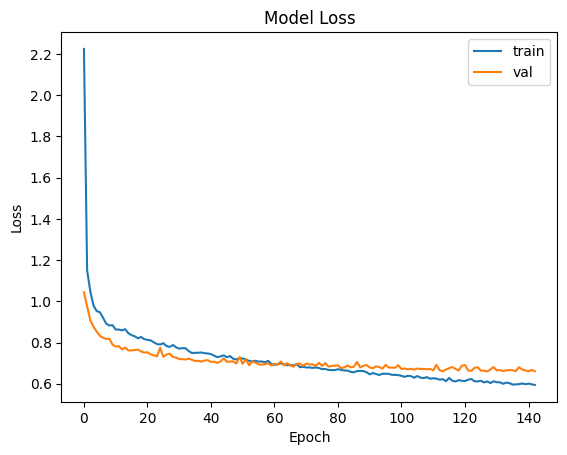

In [56]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

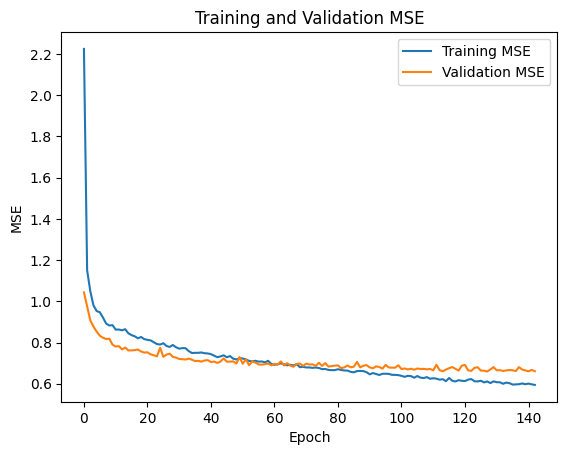

In [57]:
mse = history.history['mse']
val_mse = history.history['val_mse']
plt.plot(mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE')
plt.legend()
plt.show()

In [63]:
y_pred_rounded = np.round(y_pred)
y_test_rounded = np.round(y_test)

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import numpy as np


y_predict = np.round(y_pred).astype(int)
y_tests = np.round(y_test).astype(int)

precision = precision_score(y_tests, y_predict, average='macro')
recall = recall_score(y_tests, y_predict, average='macro')
f1 = f1_score(y_tests, y_predict, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


print(classification_report(y_tests, y_predict))

cm = confusion_matrix(y_tests, y_predict)

Precision: 0.3927245871257514
Recall: 0.26667782354145037
F1 Score: 0.271901199794404
              precision    recall  f1-score   support

           1       0.79      0.12      0.20       260
           2       0.48      0.42      0.45       965
           3       0.45      0.66      0.53      1265
           4       0.39      0.37      0.38       750
           5       0.24      0.04      0.07       183
           6       0.00      0.00      0.00        39

    accuracy                           0.45      3462
   macro avg       0.39      0.27      0.27      3462
weighted avg       0.46      0.45      0.42      3462



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

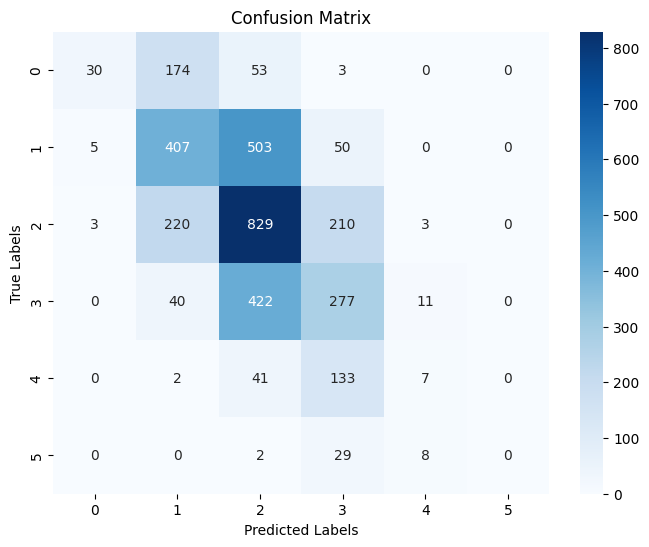

In [65]:

num_classes = len(np.unique(y_test))


class_labels = list(range(num_classes))


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

En analysant la matrice de confusion , on voit que il y a beacuoup de scores qui ont été mal prédis mais il restent très proche du vrai score

In [ ]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test_rounded, y_pred_rounded, weights='quadratic')

In [38]:
print('Quadratic Weighted Kappa:', kappa)

Quadratic Weighted Kappa: 0.733569880678268


Le kappa score s'est nettement amélioré

SVR avec nouvelle feature

In [47]:
df1

,essay_id,full_text,score,theme
0,000d118,many people car live thing know use car alot t...,3,2
1,000fe60,scientist nasa discussing face mars explaining...,3,3
2,001ab80,people always wish technology seen movies best...,4,2
3,001bdc0,heard venus planet without almost oxygen earth...,4,1
4,002ba53,dear state senator letter argue favor keeping ...,3,4
...,...,...,...,...
17302,ffd378d,story challenge exploing venus informative pie...,2,1
17303,ffddf1f,technology changed lot ways live today nowaday...,4,3
17304,fff016d,like sitting around day great opportunity part...,2,3
17305,fffb49b,challenge exporing venus author suggests study...,1,1


**Ajout d'une autre feature : le nombre de mots par texte**

In [48]:
def count_words(text):
    return len(text.split())


In [49]:

df1['number_of_words'] = df1['full_text'].apply(count_words)


In [22]:
df1


,essay_id,full_text,score,theme,number_of_words
0,000d118,many people car live thing know use car alot t...,3,2,238
1,000fe60,scientist nasa discussing face mars explaining...,3,3,135
2,001ab80,people always wish technology seen movies best...,4,2,274
3,001bdc0,heard venus planet without almost oxygen earth...,4,1,246
4,002ba53,dear state senator letter argue favor keeping ...,3,4,182
...,...,...,...,...,...
17302,ffd378d,story challenge exploing venus informative pie...,2,1,76
17303,ffddf1f,technology changed lot ways live today nowaday...,4,3,299
17304,fff016d,like sitting around day great opportunity part...,2,3,90
17305,fffb49b,challenge exporing venus author suggests study...,1,1,130


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df1['full_text'])

tranformation en array numpy pour que toutes données soient au meme format

In [24]:
X_dense = X.toarray()


In [25]:
theme_array = df1['theme'].to_numpy()
word_count_array = df1['number_of_words'].to_numpy()


In [ ]:
import numpy as np
X_combined = np.column_stack((X_dense, theme_array, word_count_array))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVR

svr_model = SVR(kernel='linear')

svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)


In [ ]:
y_pred_rounded = np.round(y_pred_svr)
y_test_rounded = np.round(y_test)

Accuracy = accuracy_score(y_test_rounded, y_pred_rounded)
Precision = precision_score(y_test_rounded, y_pred_rounded, average='macro')
Recall = recall_score(y_test_rounded, y_pred_rounded, average='macro')from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test_rounded, y_pred_rounded, weights='quadratic')

In [6]:
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print('Quadratic Weighted Kappa:', kappa)

Accuracy: 0.621265064646714
Precision: 0.5273736375049118
Recall: 0.40461700534185147
Quadratic Weighted Kappa: 0.8141851455617225


En ajoutant les deux clonnes, nombre de mots et theme, le score s'est nettement améliorer